In [21]:
import re
import nltk
import time
import spacy
import pickle
import string
import swifter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#set warning
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

In [10]:
filename = '../database/test_data.csv'
df = pd.read_csv(filename, encoding = 'latin-1')
df

,tweet,label
0,"Insya Allah, Partai Bulan Bintang akan masuk k...",positif
1,"Gila, Dedi gak ada bosannya puji-puji Prabowo ...",negatif
2,@CNNIndonesia Yakin sih gua Pemilu 2024 bakal ...,negatif
3,"Jangan Ada Polarisasi di Pemilu 2024, Golkar I...",negatif
4,@aguswkweka @pengarang_sajak @psi_id Silahkan ...,positif
...,...,...
195,@NMS__ampelDenta Saran saya buat bohir demo in...,positif
196,Ganjar Pranowo calon Presiden 2024 penerus Pre...,positif
197,"Gw bukan orang goblok, karena ngak dukung Yama...",negatif
198,Stlah bicara gagasan di @MataNajwa via @narasi...,positif


### **Preprocessing Data**

In [11]:
class TextPreprocessor:
    def __init__(self, normalisasi_path='machine/preprocessing/normalisasi.csv', stopword_path='machine/preprocessing/stopword.csv'):
        self.normalized_word_dict = self.load_normalization(normalisasi_path)
        self.stopwords = self.load_stopwords(stopword_path)
        self.stemmer = self.create_stemmer()

    def load_normalization(self, path):
        normalized_word = pd.read_csv(path, encoding='latin1')
        normalized_word_dict = {}
        for index, row in normalized_word.iterrows():
            if row[0] not in normalized_word_dict:
                normalized_word_dict[row[0]] = row[1]
        return normalized_word_dict

    def load_stopwords(self, path):
        txt_stopword = pd.read_csv(path, header=None, names=["stopwords"])
        additional_stopwords = list(txt_stopword["stopwords"][0].split(' '))
        factory = StopWordRemoverFactory()
        stopword_sastrawi = factory.get_stop_words()
        stopword = stopword_sastrawi + additional_stopwords + ["petrus", "sech", "bulakparen", "dcs", "mug","apa", "dkk", "kek","bla","nihhh","nyinyir",
                    "background2","nya", "klik", "nih", "wah", "bd","cie", "wahh", "gtgt", "wkwkw", "grgr", "thun", "dong", "mkmk","gp","brengkelan","woi",
                    "twit", "iii", "08alian", "wkwkwkwk", "wkwk","wkwkwk", "ah", "ampnbsp", "bawaslu", "hihihi", "hihi", "eh", "ng","dl","do","kwkwkwkk",
                    "ltpgtampnbspltpgt", "dancukkk", "yach", "kepl", "wow","kretek", "woww", "smpn", "hmmmm", "hehe", "oooiii","onana","kjaernett",
                    "hahaha", "ppp", "nek", "rang", "tuh", "pls", "otw", "pas","haha", "ha", "hahahahaha", "hahahasenget","wakakakakak","wkwkwkw",
                    "xixixixi", "hehehehee", "nder", "aduuuhhh", "lah","lah", "deh", "si", "kan", "njirrrr", "huehehee","yoongi","sulli","bjir",
                    "hehehe", "yahh", "yah", "loh", "elo", "gw", "didkgkl","sih", "lu", "yeyeye", "dlllllllllll", "se","yoon","de","ruu","apeeeeee",
                    "pisss", "yo", "kok", "nge", "wkwkkw", "dah", "wahhh", "apa", "btw", "kwkwkwkwk", "nahh", "nah", "iya"]
        return stopword

    def create_stemmer(self):
        factory = StemmerFactory()
        return factory.create_stemmer()

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r"@\S+", "", text)
        text = re.sub(r'(@[^\s]+|http\S+|#\w+|<.*?>)', '', text)
        text = re.sub(r'\b[a-zA-Z]\b', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.encode('ascii', 'replace').decode('ascii')
        text = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(text.split())

    def tokenize_text(self, text):
        regexp = RegexpTokenizer(r'\w+|\$[0-9]+|\S+')
        tokens = regexp.tokenize(text)
        return tokens

    def normalized_term(self, document):
        return [self.normalized_word_dict[term] if term in self.normalized_word_dict else term for term in document]

    def filter_stopwords(self, text):
        return [word for word in text if word not in self.stopwords]

    def stemmed_wrapper(self, term):
        return self.stemmer.stem(term)

    def stemming_text(self, text):
        return [self.stemmed_wrapper(term) for term in text]

    def preprocess_text(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)
        normalized_tokens = self.normalized_term(tokens)
        filtered_tokens = self.filter_stopwords(normalized_tokens)
        stemmed_tokens = self.stemming_text(filtered_tokens)

        # Gabungkan hasil stemmed_tokens menjadi satu kalimat
        processed_text = ' '.join(stemmed_tokens)
        return processed_text

In [12]:
# Mengubah nilai label positif menjadi 1 dan nilai negatif menjadi 0
label_mapping = {'positif': 1, 'negatif': 0}
df['label'] = df['label'].map(label_mapping)

# Proses preprocessing data
preprocessor = TextPreprocessor()
df['tweet_clean'] = df['tweet'].apply(preprocessor.preprocess_text)

### **Support Vector Machine With Feature Selection** 

In [13]:
# Memanggil model yang digunakan
def load_model(file_path):
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    return model

tfidf_vectorizer = load_model('machine/tfidf_vectorizer.pkl')
feature_selector = load_model('machine/feature_selector.pkl')
svm_classifier = load_model('machine/svm_classifier.pkl')

# Mengubah tweet menjadi vektor fitur TF-IDF
tfidf_features = tfidf_vectorizer.transform(df['tweet_clean'])

# Lakukan pemilihan fitur 
selected_features = feature_selector.transform(tfidf_features)

# Buat prediksi menggunakan model SVM
predictions = svm_classifier.predict(selected_features)

# Tambahkan prediksi ke DataFrame
df['prediction'] = predictions

In [14]:
df

,tweet,label,tweet_clean,prediction
0,"Insya Allah, Partai Bulan Bintang akan masuk k...",1,insya allah partai bulan bintang masuk parlame...,1
1,"Gila, Dedi gak ada bosannya puji-puji Prabowo ...",0,gila dedi bosan pujipuji prabowo subianto,0
2,@CNNIndonesia Yakin sih gua Pemilu 2024 bakal ...,0,yakin pilih bakal curang kpu lembek begini najis,0
3,"Jangan Ada Polarisasi di Pemilu 2024, Golkar I...",0,jangan polarisasi pilih golkar pilih lebih bai...,0
4,@aguswkweka @pengarang_sajak @psi_id Silahkan ...,1,sila senang hati kalian siap teman rawan ganja...,1
...,...,...,...,...
195,@NMS__ampelDenta Saran saya buat bohir demo in...,1,saran buat bohir demo mending duit simpan logi...,1
196,Ganjar Pranowo calon Presiden 2024 penerus Pre...,1,ganjar pranowo calon presiden terus presiden j...,1
197,"Gw bukan orang goblok, karena ngak dukung Yama...",0,bukan orang bodoh dukung yaman,0
198,Stlah bicara gagasan di @MataNajwa via @narasi...,1,bicara gagas via dari situ jelas pilih mantab ...,0


In [15]:
# Hitung matriks evaluasi
accuracy = accuracy_score(df['label'], df['prediction'])
precision = precision_score(df['label'], df['prediction'])
recall = recall_score(df['label'], df['prediction'])
f1 = f1_score(df['label'], df['prediction'])

# Waktu prediksi
start_time = time.time()
predictions = svm_classifier.predict(selected_features)
elapsed_time = time.time() - start_time

# Tambahkan prediksi ke DataFrame
df['prediction'] = predictions

# Tambahkan hasil evaluasi ke dalam DataFrame
evaluation_results = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'Time (s)': [elapsed_time]
})

# Tampilkan hasil evaluasi
print("Evaluation Results:")
print(evaluation_results)


Evaluation Results:
   Accuracy  Precision  Recall  F1-Score  Time (s)
0       0.9   0.908163    0.89   0.89899  0.008899


In [29]:
from sklearn.metrics import classification_report

# Hitung matriks evaluasi
report = classification_report(df['label'], df['prediction'])

# Tampilkan hasil evaluasi
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       100
           1       0.91      0.89      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



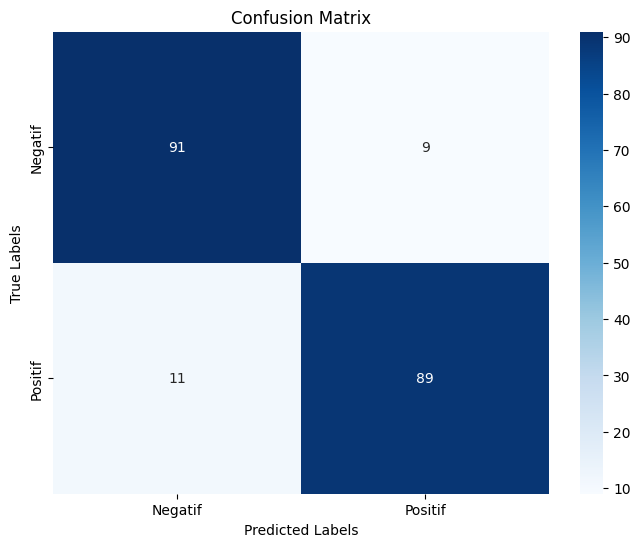

In [22]:
# Menghitung confusion matrix dari kolom label dan prediction dalam DataFrame df
conf_matrix = confusion_matrix(df['label'], df['prediction'])

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Menghitung confusion matrix dari kolom label dan prediction dalam DataFrame df
conf_matrix = confusion_matrix(df['label'], df['prediction'])

# Konversi confusion matrix menjadi DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Menampilkan confusion matrix dalam bentuk tabel
print("Confusion Matrix:")
print(conf_matrix_df)


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0           91            9
Actual 1           11           89
